## This notebook specifically targets the binary classifier, i.e. to predict if it is an attack or a benign case.
**Sujal Adhikari**

In [56]:
### Libraries that we will be using:

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, accuracy_score,recall_score,f1_score,roc_curve,roc_auc_score, precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [21]:
### Dataset we will be using 
data = pd.read_csv('../Datasets/pre-processedData.csv')

## We will be excluding the column named 'Severity_Score'
binary_data = data.drop(columns=['Severity_Score', 'Unnamed: 0'])
binary_data.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,flag_REJ,flag_RSTO,flag_RSTR,flag_S1,flag_S3,flag_SF,flag_SH,is_malicious,bytes_ratio,total_bytes
0,0.0,6.198479,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,6.198479,6.198479
1,0.0,4.990433,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,4.990433,4.990433
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0,0.0,0,...,0,0,0,0,0,0,0,1,0.000000,0.000000
3,0.0,5.451038,9.006264,0.0,0.0,0.0,0.0,1,0.0,0,...,0,0,0,0,0,1,0,0,0.544763,14.457302
4,0.0,5.298317,6.042633,0.0,0.0,0.0,0.0,1,0.0,0,...,0,0,0,0,0,1,0,0,0.752321,11.340950


### Test-Train Split

In [22]:
X = binary_data.drop(columns='is_malicious')
y = binary_data['is_malicious']

## Train_Test Split 
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=RANDOM_SEED)

---
## Models 

### Model 1: Logistic Regression

In [23]:
## Pipeline creation 
pipeline_steps= [('scaler', StandardScaler()), ('logit', LogisticRegression(solver='liblinear', max_iter = 1000, class_weight=
'balanced', C = 100, penalty='l2'))]
logit_pipeline = Pipeline(pipeline_steps)

logit_pipeline.fit(X_train,y_train)


/opt/anaconda3/envs/Network_Intrusion/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('logit', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",100
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with 

In [39]:
logit_testing_pred = logit_pipeline.predict(X_test)
logit_training_pred = logit_pipeline.predict(X_train)

logit_testing_proba = logit_pipeline.predict_proba(X_test)[:,1]
logit_training_proba = logit_pipeline.predict_proba(X_train)[:,1]

### Performance Matrix:

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     15450
           1       0.96      0.98      0.97     14254

    accuracy                           0.97     29704
   macro avg       0.97      0.97      0.97     29704
weighted avg       0.97      0.97      0.97     29704



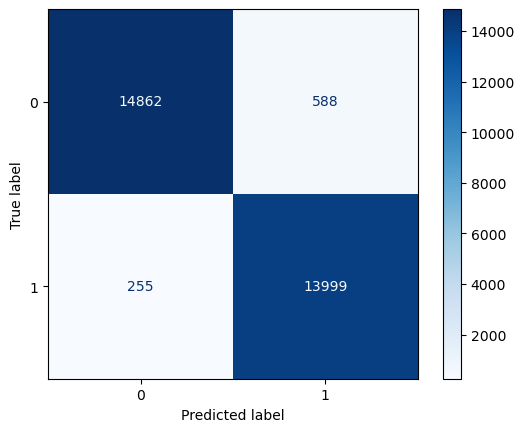

In [42]:
## Precision
logit_precision = precision_score(y_test, logit_testing_pred) ## 

## Recall
logit_recall = recall_score(y_test, logit_testing_pred) ## Attack Detection Rate

## F1-Score
logit_f1 = f1_score(y_test, logit_testing_pred) ## Harmonic Mean between precision and recall

## Classification Report
logit_report = classification_report(y_test, logit_testing_pred)
print(logit_report)

### Confusion Matrix and Plotting Confusion Matrix 
logit_matrix = confusion_matrix(y_test, logit_testing_pred)
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, logit_testing_pred ).ravel()

### False Positive Rate: 
logit_false_positive_rate = (false_positives)/(true_negatives+false_positives) ## Wrongly Identified Attack

logit_false_negative_rate = (false_negatives)/(true_positives+false_negatives) ## Attack Missed Rate

##Confusion Matrix Display 
logit_confusion_display = ConfusionMatrixDisplay(confusion_matrix=logit_matrix) 
logit_confusion_display.plot(cmap='Blues')
plt.show()

## Roc_auc_score
logit_roc_score = roc_auc_score(y_test, logit_testing_proba)


---
### Model 2: Linear SVM 

In [32]:
pipeline_steps = [('scaler', StandardScaler()),('svm', LinearSVC(loss = 'hinge', max_iter=1000, random_state=RANDOM_SEED,C=10))]
svm_pipeline = Pipeline(pipeline_steps)
svm_pipeline.fit(X_train, y_train)

/opt/anaconda3/envs/Network_Intrusion/lib/python3.14/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [ ]:
svm_training_pred = svm_pipeline.predict(X_train)
svm_testing_pred = svm_pipeline.predict(X_test)

svm_training_boundary = svm_pipeline.predict(X_train)
svm_testing_boundary = svm_pipeline.predict(X_test)



0.9591642278636086
0.988704924933352
0.9737105744982208
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     15450
           1       0.96      0.99      0.97     14254

    accuracy                           0.97     29704
   macro avg       0.97      0.97      0.97     29704
weighted avg       0.97      0.97      0.97     29704



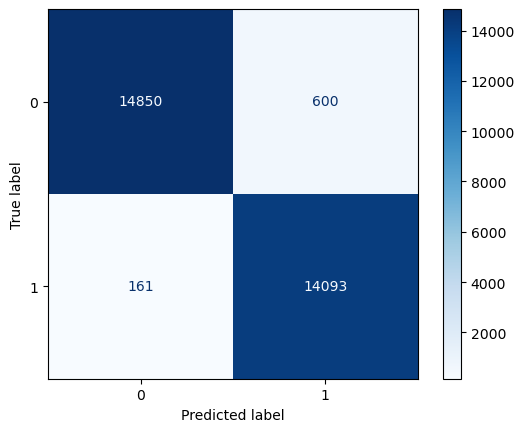

In [ ]:
### Evaluation Metrics

svm_precision = precision_score(y_test, svm_testing_pred)
print(svm_precision)
svm_recall = recall_score(y_test, svm_testing_pred)
print(svm_recall)
svm_f1 = f1_score(y_test, svm_testing_pred)
print(svm_f1)

### Classification report 
svm_report = classification_report(y_test, svm_testing_pred)
print(svm_report)

### Confusion Matrix 
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, svm_testing_pred).ravel()
svm_matrix = confusion_matrix(y_test, svm_testing_pred)

svm_display = ConfusionMatrixDisplay(confusion_matrix=svm_matrix)
svm_display.plot(cmap = 'Blues')
plt.show()

### False Negative Rate 
svm_false_negative_rate = (false_negatives)/(false_negatives+ true_positives)
svm_false_positive_rate = (false_positives)/(false_positives+true_negatives)




---
### Model 3: Gaussian NB 


In [ ]:
## Since it is not a linear model we wont put the pipeline such as Standard Scaler for the measurment

naive_model = GaussianNB(var_smoothing=1e-9) ## To make sure that there no zero division error
naive_model.fit(X_train, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [49]:
naive_training_pred = naive_model.predict(X_train)
naive_testing_pred = naive_model.predict(X_test)

naive_training_proba = naive_model.predict_proba(X_train)
naive_testing_proba = naive_model.predict_proba(X_test)[:,1]




              precision    recall  f1-score   support

           0       0.93      0.91      0.92     15450
           1       0.90      0.93      0.91     14254

    accuracy                           0.92     29704
   macro avg       0.92      0.92      0.92     29704
weighted avg       0.92      0.92      0.92     29704



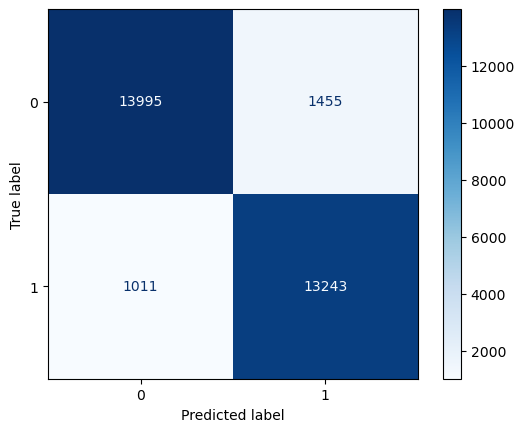

In [51]:
## Precision 

naive_precision = precision_score(y_test, naive_testing_pred)

## Recall 
naive_recall = precision_score(y_test, naive_testing_pred)

## F1-Score

naive_f1 = f1_score(y_test, naive_testing_pred)

## Classification Report

naive_report = classification_report(y_test, naive_testing_pred)
print(naive_report)

## Confusion Matrix
naive_evaluation_matrix = confusion_matrix(y_test, naive_testing_pred)
display = ConfusionMatrixDisplay(confusion_matrix=naive_evaluation_matrix)
display.plot(cmap="Blues")

# ConfusionMatrix Properties
true_negatives, false_positives, false_negatives, true_positives = confusion_matrix(y_test, naive_testing_pred).ravel()

naive_false_positive_rate = (false_positives) /( false_positives + true_negatives) ## Attack Missed Rate

naive_false_negative_rate = (false_negatives) / (false_negatives + true_positives) ## False Alarm 



## Roc_auc score
naive_roc_score = roc_auc_score(y_test, naive_testing_proba)

---
### Model 4: Decision Tree Classifier 

In [67]:
decision_model = DecisionTreeClassifier(criterion='gini', max_depth = 12, max_features = 14, min_samples_leaf = 150, min_samples_split = 410, random_state=RANDOM_SEED)

decision_model.fit(X_train,y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",410
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",150
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",14
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

In [68]:
decision_training_pred = decision_model.predict(X_train)
decision_testing_pred = decision_model.predict(X_test)


## Training and Testing Proba

decision_training_proba = decision_model.predict_proba(X_train)[:,1]
decision_testing_proba = decision_model.predict_proba(X_test)[:,1]

